### imports and a couple useful functions:

In [13]:
from __future__ import print_function, division

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)

from tensorflow import keras
from tensorflow.keras import layers, regularizers

from tqdm import tqdm
from glob import glob
import datetime
import os, sys

pd.options.display.max_rows = 30
pd.options.display.max_columns = 40

from collections import OrderedDict

## some useful team data in here (converters from short to long):
from basketball_reference_web_scraper import data

years = np.arange(1950, 2019)

## custom printing for my Keras training:
class PrintCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 25 == 0:
            print("epoch {}:  loss = {:.2f}, test loss = {:.2f}".format(
                epoch, logs['loss'], logs['val_loss']))
    def on_train_begin(self, logs={}):
        print("Beginning training...")
    
    def on_train_end(self, logs):
        print("Training completed")

early_stopper = keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
nan_stopper = keras.callbacks.TerminateOnNaN()
        
def find_player_id(player_name, df):
    possible_pids = np.unique(df.index[df['player_name'] == player_name])
    if possible_pids.size == 1:
        return possible_pids[0]
    elif possible_pids.size > 1:
        print("Many options; returning most average points:")
        vals = []
        for pid in possible_pids:
            rows = df.loc[df.index==pid]
            mean_points = np.average(rows['points'])
            vals.append(mean_points)
            print(f'\t{pid} with an average point/year of {mean_points}'.format(
                row['PlayerID'], row['CareerValue']))
        return possible_pids[np.argmax(vals)]
    else:
        print("No exact name matches... possible names:")
        from fuzzywuzzy import process
        matches = process.extract(player_name, np.unique(df['player_name'].values), limit=10)
        for poss in matches:
            print("\t",poss[0])
        print("Returning best match, but maybe incorrect...")
        return find_player_id(matches[0][0], df)
    
class CyclicList(list):
    def __getitem__(self, index):
        return super().__getitem__(index%len(self))

### functions that implement recommendations on network size:

In [2]:
def recommended_max_hidden_neurons_hobbs(training_sample_size, 
                                   num_input_neurons, 
                                   num_output_neurons,
                                  alpha=2.5):
    """
    recommend the max number of hidden neurons based on I/O & sample size
    
    this recommendation is taken from the second answer (from @hobbs) on
    stackexchange here:  

    https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    """
    
    bottom = alpha * (num_input_neurons + num_output_neurons)
    return training_sample_size/bottom

def recommend_max_hidden_neurons_heaton(num_input_neurons,
                                       num_output_neurons):
    """
    following the third answer, from @jj_, who quotes Heaton,
    we have three rules of thumb:

    * The number of hidden neurons should be between the size 
      of the input layer and the size of the output layer.
    
    * The number of hidden neurons should be 2/3 the size of 
      the input layer, plus the size of the output layer.
    
    * The number of hidden neurons should be less than twice 
      the size of the input layer.    
    """
    
    ## rule one:
    max_size = max([num_input_neurons, num_output_neurons])
    min_size = min([num_input_neurons, num_output_neurons])
    print(f"\tRule one recommends {min_size} - {max_size}")
    
    ## rule two:
    size = np.rint(2*num_input_neurons/3) + num_output_neurons
    print(f"\tRule two recommends {size}", end='')
    if min_size < size < max_size:
        print(", which also satisfies rule 1")
    else:
        print(", which is in conflict with rule 1")
    
    ## rule three:
    max_size_two = 2*num_input_neurons
    print(f"\tRule three recommends no more than {2*max_size_two}")

## extract test/training/validate and make recommendations:

In [3]:
def build_training_dataframe(yearly_df, player_df, 
                             training_columns, target_column, 
                             years_to_train_on=2, frac_train=0.75,
                             min_career_length=3, 
                             sort_before_splitting=True,
                             split_randomly=True,
                             drop_pre_1973=True):
    
    assert target_column not in training_columns
    
    msk = player_df['career_length']>=min_career_length
    if drop_pre_1973:
        msk *= player_df['rookie_end_year'] >= 1973
        
    player_subset = player_df.loc[msk]
    
    input_data = []
    
    ## loop over players that meet my requirements
    for pid in player_subset.index:
        ## grab the rows correspoding to that player
        rows = yearly_df.loc[pid]
        
        ## create a dictionary for each player
        pdata = dict(player_id=pid)
        
        ## add the data for the first n years (where n = years_to_train_on) 
        ## of that players career to their dictionary
        for ii in range(years_to_train_on):
            for k in training_columns:
                pdata[k+f'.y{ii+1}'] = rows[k].iloc[ii]
                
        input_data.append(pdata)
    
    ## now turn that dictionary back into a dataframe
    input_data = pd.DataFrame(input_data)
    input_data.set_index('player_id', inplace=True)

    ## and pull the targets out of our original dataset
    target_data = player_subset[target_column]
    if sort_before_splitting:
        input_data[target_column] = target_data
        input_data.sort_values(target_column, inplace=True)
        target_data = input_data.pop(target_column)
    
    total_sample_size = len(target_data)
    all_indices = np.arange(total_sample_size)

    if split_randomly:
        ntrain = int(np.ceil(frac_train*total_sample_size))
        ntest = int(np.ceil((1-frac_train)*total_sample_size/2))
        nvalidate = int(np.ceil((1-frac_train)*total_sample_size/2))

        while ntest + ntrain + nvalidate > total_sample_size:
            ntest -= 1        
        
        train_indices = np.random.choice(all_indices, size=ntrain, replace=False)
        all_indices = np.setdiff1d(all_indices, train_indices)
        
        test_indices = np.random.choice(all_indices, size=ntest, replace=False)
        all_indices = np.setdiff1d(all_indices, test_indices)
        
        validate_indices = np.array(all_indices, copy=True)
    else:
        tt_stride = int(2/(1-frac_train))
        
        test_indices = all_indices[tt_stride//2::tt_stride]
        validate_indices = test_indices + 1
        train_indices = np.setdiff1d(all_indices, np.concatenate((test_indices, validate_indices)))
    
    trainX = input_data.iloc[train_indices]
    trainY = target_data.iloc[train_indices]
    
    testX = input_data.iloc[test_indices]
    testY = target_data.iloc[test_indices]
    
    validateX = input_data.iloc[validate_indices]
    validateY = target_data.iloc[validate_indices]
    
    return trainX, trainY, testX, testY, validateX, validateY
        

In [4]:
def extract_and_recommend(yearly_df, player_df, training_columns, target_column, **kwargs):
    trainX, trainY, testX, testY, validateX, validateY = build_training_dataframe(
        yearly_df, player_df, training_columns, target_column, **kwargs)
    
    print("Training on {} columns, so using that many input neurons".format(trainX.shape[1]))
    print("Predicting one column, so using that many output neurons")
    
    input_neurons = trainX.shape[1]
    output_neurons = 1
    
    print("@hobbs recommends {} hidden neurons max".format(
        recommended_max_hidden_neurons_hobbs(len(trainX), input_neurons, output_neurons)))
    print("Heaton recommends:")
    recommend_max_hidden_neurons_heaton(input_neurons, output_neurons)
    
    return trainX, trainY, testX, testY, validateX, validateY

### Build and train an model, optionally with hidden layers

In [43]:
def build_and_train(trainX, trainY, 
                    testX, testY, 
                    hidden_layers=None,
                    hidden_layer_neurons=None, hidden_layer_kwargs=None,
                    clear=True,
                    optimizer='Adadelta', loss='mean_squared_error',
                    epochs=250, metrics=[], shuffle=True, batch_size=None,
                    input_layer=None, input_layer_neurons=None, input_layer_kwargs=dict(),
                    output_layer=None, output_layer_neurons=1, output_layer_kwargs=dict()):

    if clear:
        print("Clearing TensorFlow graph")
        keras.backend.clear_session()
    
    model = keras.Sequential()
    
    ## add our input layer:
    if input_layer is not None:
        model.add(input_layer)
    else:
        if input_layer_neurons is None:  input_layer_neurons = trainX.shape[1]
        model.add(keras.layers.Dense(input_layer_neurons, input_shape=[trainX.shape[1]], **input_layer_kwargs))

    ## add any hidden layers
    if hidden_layers is not None:
        ## did we pass in pre-built layers?
        for layer in hidden_layers:
            model.add(layer)
    else:
        for neurons, kwargs in zip(hidden_layer_neurons, hidden_layer_kwargs):
            ## otherwise, assume all are dense
            model.add(keras.layers.Dense(neurons, **kwargs))
        
    ## add our output layer
    if output_layer is not None:
        model.add(output_layer)
    else:
        model.add(keras.layers.Dense(output_layer_neurons, **output_layer_kwargs))

    ## compile our model with our callbacks:
    cblist = [early_stopper, nan_stopper, PrintCallback()]    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    ## and fit it!
    history = model.fit(trainX, trainY, validation_data=(testX, testY),
                        epochs=epochs, verbose=0, callbacks=cblist,
                        shuffle=shuffle, batch_size=batch_size)
    
    return model, history

### Functions to check model performance:

In [19]:
def plot_history(history, skip=10, logy=False):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    keys = [k for k in history.history.keys() if not k.startswith('val_')]
    for key in keys:
        fig = plt.figure()
        ax = plt.gca()
        ax.set_xlabel('Epoch')
        ax.set_ylabel(key)
        if logy:
            ax.set_yscale('log')
        ax.plot(hist['epoch'][skip:], hist[key][skip:],
               label='Train Error')
        ax.plot(hist['epoch'][skip:], hist['val_'+key][skip:],
               label = 'Test Error')
        ax.legend()
        
def calculate_mse(model, validateX, validateY):
    prediction = model.predict(validateX).flatten()
    mse = np.mean(np.square(validateY.values - prediction))
    return mse

def plot_pred_vs_actual(model, Xlist, Ylist, labels=None, logaxes=''):
    fig = plt.figure()
    ax = plt.gca()
    ax.set_xlabel('actual')
    ax.set_ylabel('prediction')
    if 'x' in logaxes:  ax.set_xscale('log')
    if 'y' in logaxes:  ax.set_yscale('log')
    
    if labels is None:
        labels = ['_nolegend_']*len(Xlist)
    for (x, y, l) in zip(Xlist, Ylist, labels):
        pred = model.predict(x)
        actual = y.values
        
        ax.scatter(actual, pred, label=l, s=25, edgecolor=None)
    ax.legend()    
    return fig, ax

# OK, moment of truth here -- all the machinery looks set up, so let's do some model building:

### read in the data:

In [7]:
yearly_df = pd.read_hdf('scraped/all_years_combined.hdf5', 'nba_stats')
player_df = pd.read_hdf('scraped/all_years_combined.hdf5', 'player_list')

### ...and build a model!

#### Values I'm set up to train for (career-averaged/medianed/maxed/etc values)

In [8]:
player_df.keys()

Index(['career_length', 'defensive_rating-max', 'defensive_rating-mean',
       'defensive_rating-median', 'defensive_rating.combined-max',
       'defensive_rating.combined-mean', 'defensive_rating.combined-median',
       'offensive_rating-max', 'offensive_rating-mean',
       'offensive_rating-median', 'offensive_rating.combined-max',
       'offensive_rating.combined-mean', 'offensive_rating.combined-median',
       'player_efficiency_rating-max', 'player_efficiency_rating-mean',
       'player_efficiency_rating-median',
       'player_efficiency_rating.combined-max',
       'player_efficiency_rating.combined-mean',
       'player_efficiency_rating.combined-median', 'player_name',
       'primary_position', 'rookie_end_year', 'total_box_plus_minus-max',
       'total_box_plus_minus-mean', 'total_box_plus_minus-median',
       'total_box_plus_minus.combined-max',
       'total_box_plus_minus.combined-mean',
       'total_box_plus_minus.combined-median', 'total_win_shares-max',
     

#### Values I'm set up to train on (trains on the first N years worth of data for these columns):

In [9]:
count = 0
for k in yearly_df.keys():
    if '.playoffs' in k:
        continue
    print(k.ljust(50), end='')
    if count % 2 == 0:
        print()
    else:
        print(' | ', end='')
    count += 1

player_name                                       
positions                                          | age                                               
team                                               | games_played                                      
games_started                                      | minutes_played                                    
made_field_goals                                   | attempted_field_goals                             
field_goal_percent                                 | made_three_point_field_goals                      
attempted_three_point_field_goals                  | three_point_percent                               
made_two_point_field_goals                         | attempted_two_point_field_goals                   
two_point_percent                                  | effective_field_goal_percent                      
made_free_throws                                   | attempted_free_throws                             
free_throw_pe

##### First, a model based on most of the basic stats from the first two years, looking to predict the mean combined vorp:

In [17]:
trainX, trainY, testX, testY, validateX, validateY = extract_and_recommend(yearly_df, player_df,
    ['field_goal_percent', 'three_point_percent', 'attempted_free_throws', 
     'total_rebounds', 'assists', 'steals', 'blocks', 'turnovers'], 
    'vorp.combined-mean')

/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Training on 16 columns, so using that many input neurons
Predicting one column, so using that many output neurons
@hobbs recommends 37.34117647058824 hidden neurons max
Heaton recommends:
	Rule one recommends 1 - 16
	Rule two recommends 12.0, which also satisfies rule 1
	Rule three recommends no more than 64


Clearing TensorFlow graph
Beginning training...
epoch 0:  loss = 1.41, test loss = 0.64
epoch 25:  loss = 0.42, test loss = 0.45
epoch 50:  loss = 0.40, test loss = 0.42
epoch 75:  loss = 0.40, test loss = 0.42
epoch 100:  loss = 0.40, test loss = 0.44
epoch 125:  loss = 0.40, test loss = 0.43
epoch 150:  loss = 0.40, test loss = 0.42
epoch 175:  loss = 0.40, test loss = 0.42
epoch 200:  loss = 0.40, test loss = 0.42
Epoch 00208: early stopping
Training completed
MSE on validation data is 0.4694266783623167


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1416fdb38>)

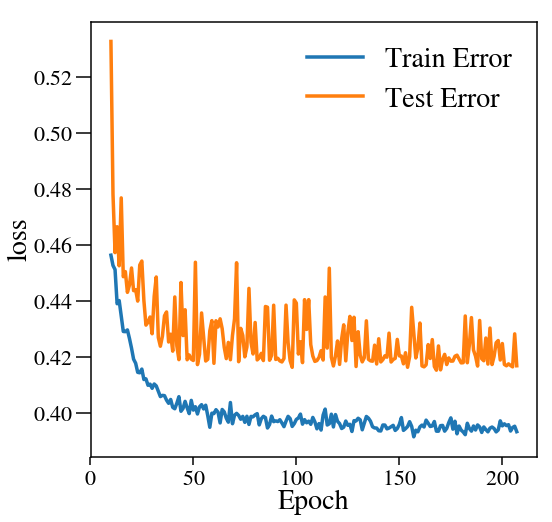

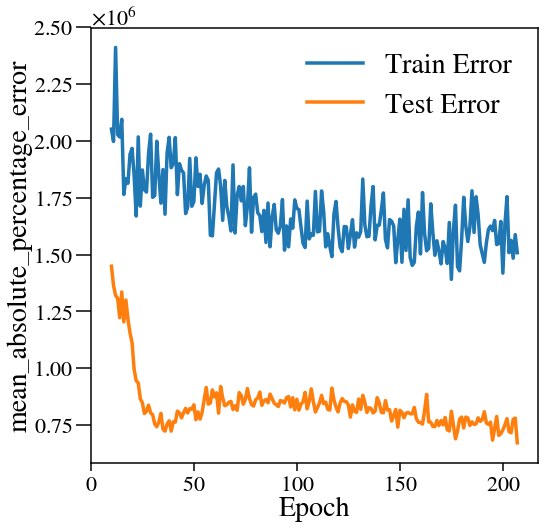

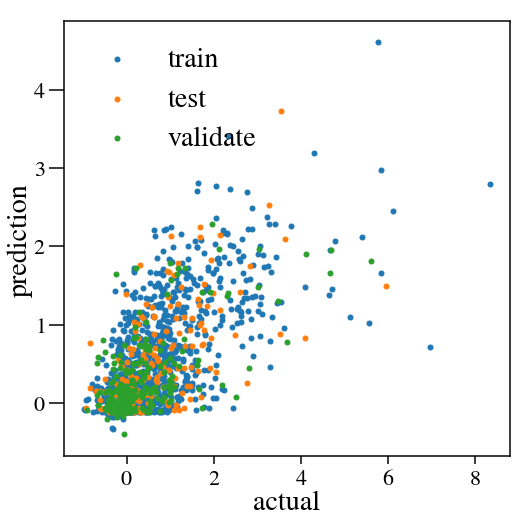

In [22]:
model, history = build_and_train(trainX, trainY, testX, testY, 
        hidden_layer_neurons=[4, 4, 4, 4], 
        hidden_layer_kwargs=[dict(activation='relu')]*4, 
        loss='mean_absolute_error', 
        metrics=['mean_absolute_percentage_error'],
        clear=True)

plot_history(history)
print("MSE on validation data is {}".format(calculate_mse(model, validateX, validateY)))
plot_pred_vs_actual(model, [trainX, testX, validateX], [trainY, testY, validateY], ['train', 'test', 'validate'])

What if I add more layers or change up the activations?

Clearing TensorFlow graph
Beginning training...
epoch 0:  loss = 1.28, test loss = 0.85
epoch 25:  loss = 0.42, test loss = 0.45
epoch 50:  loss = 0.41, test loss = 0.42
epoch 75:  loss = 0.40, test loss = 0.44
epoch 100:  loss = 0.39, test loss = 0.41
epoch 125:  loss = 0.38, test loss = 0.39
epoch 150:  loss = 0.38, test loss = 0.41
epoch 175:  loss = 0.37, test loss = 0.39
epoch 200:  loss = 0.37, test loss = 0.45
epoch 225:  loss = 0.37, test loss = 0.39
Training completed
MSE on validation data is 0.4901568011671098


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x142b564a8>)

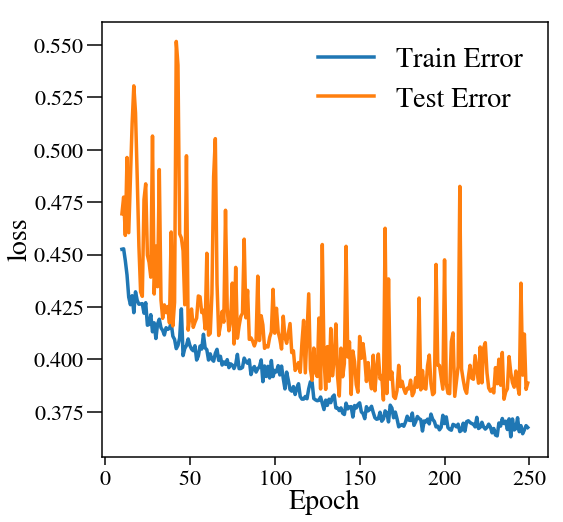

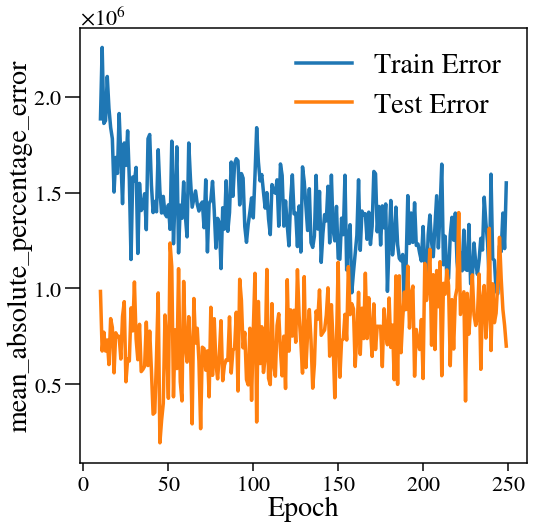

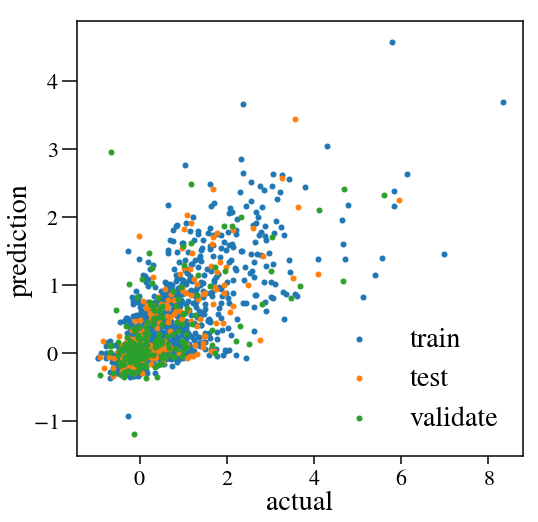

In [26]:
model, history = build_and_train(trainX, trainY, testX, testY, 
        hidden_layer_neurons=[8]*4, 
        hidden_layer_kwargs=[dict(activation='elu'), 
                             dict(activation='elu'), 
                             dict(activation='elu'), 
                             dict(activation='elu')], 
        loss='mean_absolute_error', 
        metrics=['mean_absolute_percentage_error'],
        clear=True)

plot_history(history)
print("MSE on validation data is {}".format(calculate_mse(model, validateX, validateY)))
plot_pred_vs_actual(model, [trainX, testX, validateX], [trainY, testY, validateY], ['train', 'test', 'validate'])

Clearing TensorFlow graph
Beginning training...
epoch 0:  loss = 9.90, test loss = 2.87
epoch 25:  loss = 0.43, test loss = 0.47
epoch 50:  loss = 0.41, test loss = 0.59
epoch 75:  loss = 0.41, test loss = 0.45
epoch 100:  loss = 0.40, test loss = 0.44
epoch 125:  loss = 0.40, test loss = 0.50
epoch 150:  loss = 0.40, test loss = 0.44
epoch 175:  loss = 0.39, test loss = 0.42
epoch 200:  loss = 0.39, test loss = 0.42
epoch 225:  loss = 0.39, test loss = 0.42
Training completed
MSE on validation data is 0.4832677153265137


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x142dba7f0>)

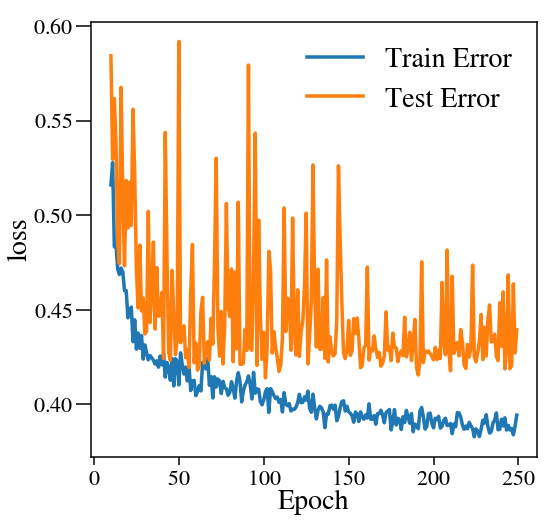

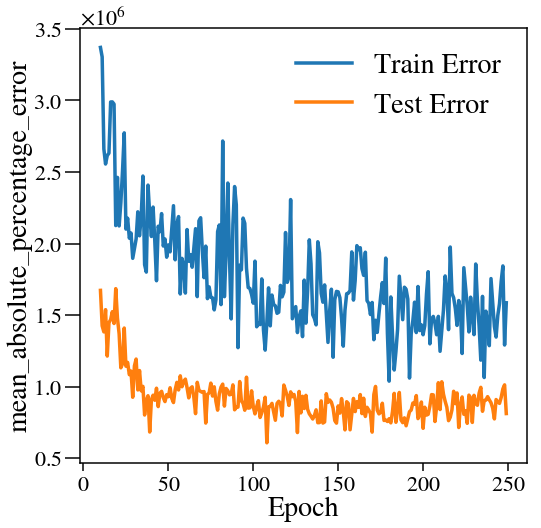

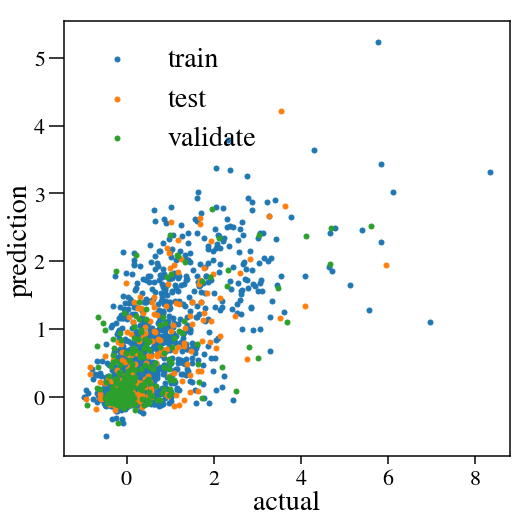

In [34]:
model, history = build_and_train(trainX, trainY, testX, testY, 
        hidden_layer_neurons=[12]*3, 
        hidden_layer_kwargs=[dict(activation='relu')]*3, 
        loss='mean_absolute_error', 
        metrics=['mean_absolute_percentage_error'],
        clear=True)

plot_history(history)
print("MSE on validation data is {}".format(calculate_mse(model, validateX, validateY)))
plot_pred_vs_actual(model, [trainX, testX, validateX], [trainY, testY, validateY], ['train', 'test', 'validate'])

#### Let's try training on advanced stats from the first couple years:

In [35]:
trainX, trainY, testX, testY, validateX, validateY = extract_and_recommend(yearly_df, player_df,
    ['player_efficiency_rating', 'true_shooting_percent', 'vorp'], 'vorp-mean')

/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Training on 6 columns, so using that many input neurons
Predicting one column, so using that many output neurons
@hobbs recommends 90.68571428571428 hidden neurons max
Heaton recommends:
	Rule one recommends 1 - 6
	Rule two recommends 5.0, which also satisfies rule 1
	Rule three recommends no more than 24


Clearing TensorFlow graph
Beginning training...
epoch 0:  loss = 1.77, test loss = 0.91
epoch 25:  loss = 0.32, test loss = 0.39
epoch 50:  loss = 0.32, test loss = 0.37
epoch 75:  loss = 0.32, test loss = 0.37
epoch 100:  loss = 0.32, test loss = 0.38
epoch 125:  loss = 0.31, test loss = 0.36
epoch 150:  loss = 0.31, test loss = 0.40
epoch 175:  loss = 0.31, test loss = 0.37
epoch 200:  loss = 0.31, test loss = 0.36
epoch 225:  loss = 0.31, test loss = 0.36
Training completed
MSE on validation data is 0.2933566174860532


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1452be908>)

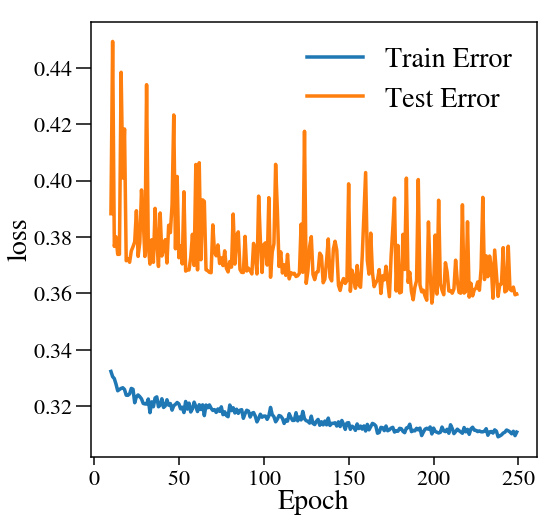

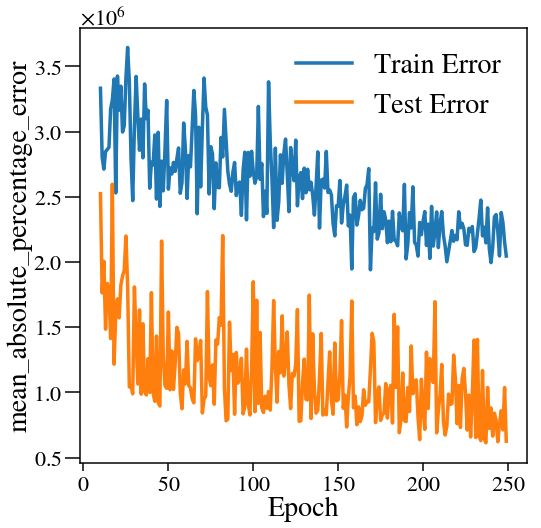

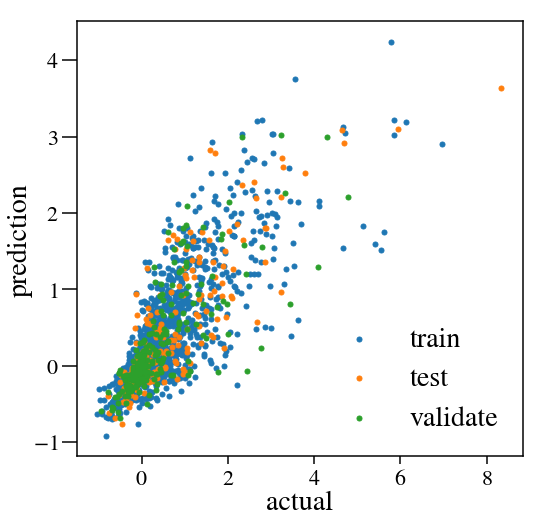

In [40]:
model, history = build_and_train(trainX, trainY, testX, testY, 
        hidden_layer_neurons=[8]*4, 
        hidden_layer_kwargs=[dict(activation='relu')]*4, 
        loss='mean_absolute_error', 
        metrics=['mean_absolute_percentage_error'],
        optimizer='RMSprop',
        clear=True)

plot_history(history)
print("MSE on validation data is {}".format(calculate_mse(model, validateX, validateY)))
plot_pred_vs_actual(model, [trainX, testX, validateX], [trainY, testY, validateY], ['train', 'test', 'validate'])

Clearing TensorFlow graph
Beginning training...
epoch 0:  loss = 0.44, test loss = 0.41
epoch 25:  loss = 0.32, test loss = 0.38
epoch 50:  loss = 0.31, test loss = 0.37
epoch 75:  loss = 0.31, test loss = 0.35
epoch 100:  loss = 0.31, test loss = 0.36
epoch 125:  loss = 0.31, test loss = 0.35
epoch 150:  loss = 0.31, test loss = 0.35
epoch 175:  loss = 0.31, test loss = 0.36
epoch 200:  loss = 0.31, test loss = 0.35
epoch 225:  loss = 0.31, test loss = 0.36
Training completed
MSE on validation data is 0.2835766378807348


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1438307b8>)

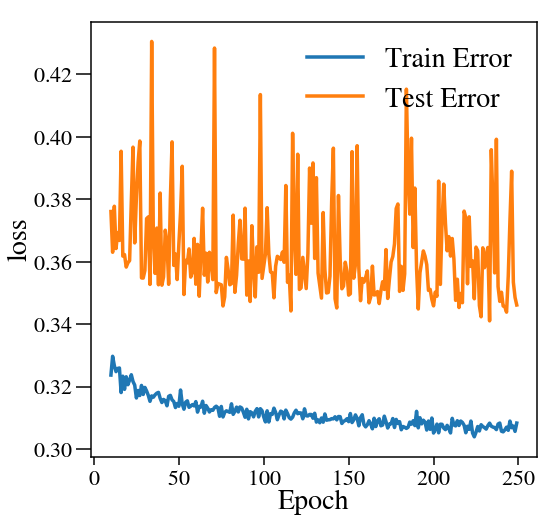

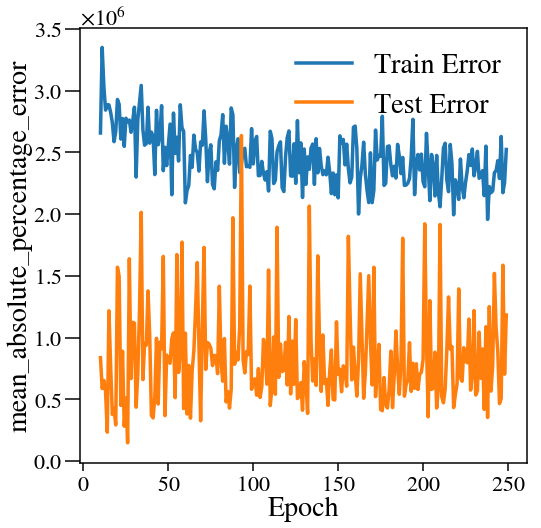

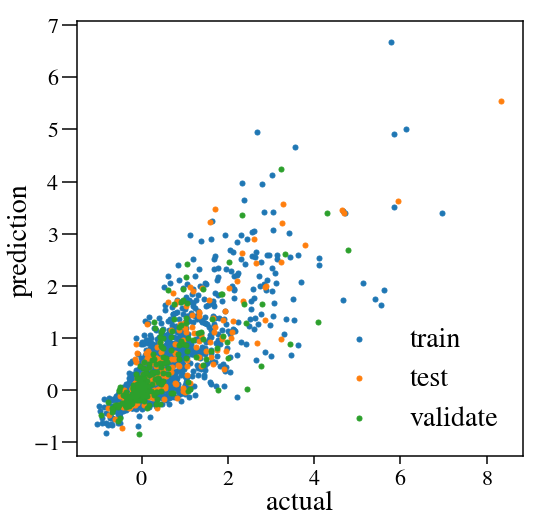

In [41]:
model, history = build_and_train(trainX, trainY, testX, testY, 
        hidden_layer_neurons=[12]*6, 
        hidden_layer_kwargs=[dict(activation='relu'), dict(activation='selu')]*3, 
        loss='mean_absolute_error', 
        metrics=['mean_absolute_percentage_error'],
        optimizer='RMSprop',
        clear=True)

plot_history(history)
print("MSE on validation data is {}".format(calculate_mse(model, validateX, validateY)))
plot_pred_vs_actual(model, [trainX, testX, validateX], 
                    [trainY, testY, validateY], 
                    ['train', 'test', 'validate'])

Clearing TensorFlow graph
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Beginning training...
epoch 0:  loss = 0.84, test loss = 0.69
epoch 25:  loss = 0.35, test loss = 0.39
epoch 50:  loss = 0.34, test loss = 0.42
epoch 75:  loss = 0.33, test loss = 0.37
epoch 100:  loss = 0.32, test loss = 0.39
epoch 125:  loss = 0.33, test loss = 0.41
epoch 150:  loss = 0.33, test loss = 0.39
epoch 175:  loss = 0.32, test loss = 0.40
epoch 200:  loss = 0.32, test loss = 0.41
epoch 225:  loss = 0.32, test loss = 0.35
Training completed
MSE on validation data is 0.32568714423567935


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x145e7cfd0>)

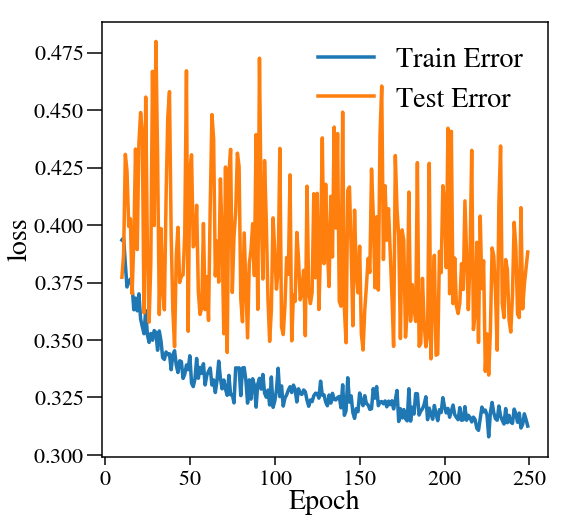

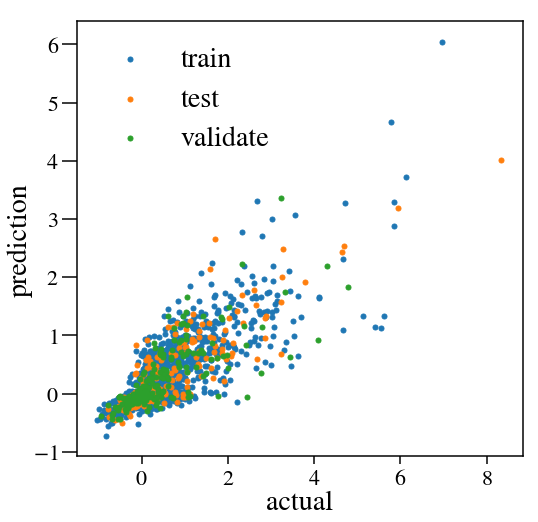

In [44]:
hidden_layers = [keras.layers.Dense(128, activation='relu'), keras.layers.Dense(128, activation='linear'), keras.layers.Dropout(rate=0.5), 
                 keras.layers.Dense(64, activation='relu'), keras.layers.Dense(64, activation='linear'), keras.layers.Dropout(rate=0.5),
                 keras.layers.Dense(32, activation='relu'), keras.layers.Dense(32, activation='linear'), keras.layers.Dropout(rate=0.25), 
                 keras.layers.Dense(16, activation='relu'), keras.layers.Dense(16, activation='linear'), keras.layers.Dropout(rate=0.125)]

model, history = build_and_train(trainX, trainY, testX, testY,  
                                 hidden_layers=hidden_layers, 
                                 loss='mean_absolute_error', optimizer='adam' 
                                 clear=True, batch_size=24)

plot_history(history)
print("MSE on validation data is {}".format(calculate_mse(model, validateX, validateY)))
plot_pred_vs_actual(model, [trainX, testX, validateX], [trainY, testY, validateY], ['train', 'test', 'validate'])

#### What if I randomly sample, rather than making sure I have high points in my test/train?

In [58]:
trainX, trainY, testX, testY, validateX, validateY = extract_and_recommend(yearly_df, player_df,
    ['player_efficiency_rating', 'true_shooting_percent', 'vorp', 'total_box_plus_minus'], 
    'vorp-mean', sort_before_splitting=False, frac_train=0.8, split_randomly=True)

/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Training on 8 columns, so using that many input neurons
Predicting one column, so using that many output neurons
@hobbs recommends 75.2 hidden neurons max
Heaton recommends:
	Rule one recommends 1 - 8
	Rule two recommends 6.0, which also satisfies rule 1
	Rule three recommends no more than 32


Clearing TensorFlow graph
Beginning training...
epoch 0:  loss = 0.73, test loss = 0.56
epoch 25:  loss = 0.29, test loss = 0.30
epoch 50:  loss = 0.29, test loss = 0.31
epoch 75:  loss = 0.29, test loss = 0.31
epoch 100:  loss = 0.29, test loss = 0.32
Epoch 00124: early stopping
Training completed
MSE on validation data is 0.28078637455113514


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x148003668>)

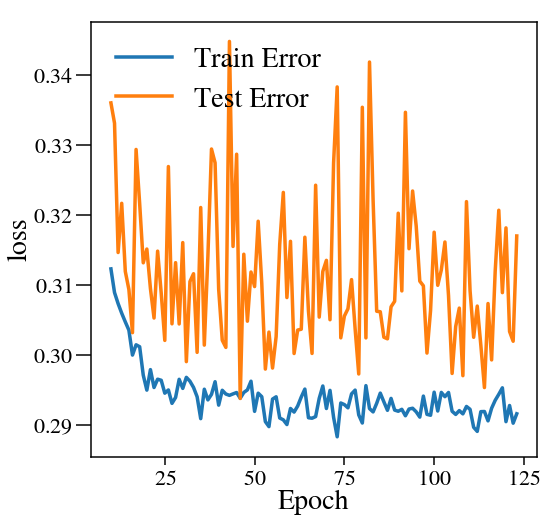

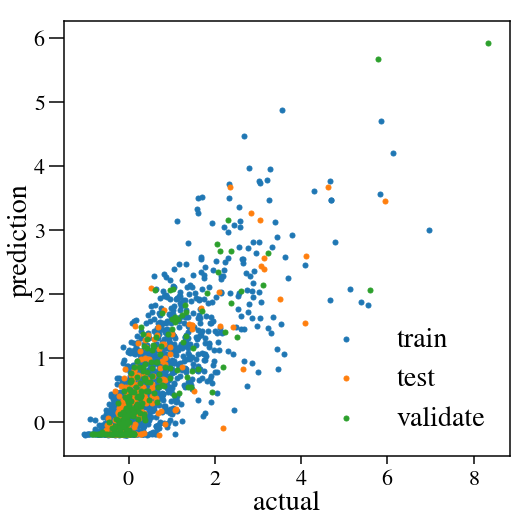

In [62]:
hidden_layers = [
     keras.layers.Dense(4, activation='relu'),# keras.layers.Dense(128, activation='linear'), keras.layers.Dropout(rate=0.5), 
     keras.layers.Dense(4, activation='relu'),# keras.layers.Dense(64, activation='linear'), keras.layers.Dropout(rate=0.5),
     keras.layers.Dense(4, activation='relu'),# keras.layers.Dense(32, activation='linear'), keras.layers.Dropout(rate=0.25), 
     keras.layers.Dense(4, activation='relu'),# keras.layers.Dense(16, activation='linear'), keras.layers.Dropout(rate=0.125)
]

model, history = build_and_train(trainX, trainY, testX, testY,  
                                 hidden_layers=hidden_layers, 
                                 loss='mse', optimizer='RMSprop',
                                 clear=True, batch_size=8)

plot_history(history)
print("MSE on validation data is {}".format(calculate_mse(model, validateX, validateY)))
plot_pred_vs_actual(model, [trainX, testX, validateX], [trainY, testY, validateY], ['train', 'test', 'validate'])

#### What if I go hog-wild and train on literally every stat I have?

In [65]:
yearly_df

,player_name,positions,age,team,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,field_goal_percent,made_three_point_field_goals,attempted_three_point_field_goals,three_point_percent,made_two_point_field_goals,attempted_two_point_field_goals,two_point_percent,effective_field_goal_percent,made_free_throws,attempted_free_throws,free_throw_percent,...,turnovers_per_36_minutes,turnovers_per_36_minutes.playoffs,personal_fouls_per_game,personal_fouls_per_game.playoffs,personal_fouls_per_36_minutes,personal_fouls_per_36_minutes.playoffs,points_per_game,points_per_game.playoffs,points_per_36_minutes,points_per_36_minutes.playoffs,vorp.combined,total_box_plus_minus.combined,player_efficiency_rating.combined,true_shooting_percent.combined,effective_field_goal_percent.combined,total_win_shares.combined,offensive_rating.combined,defensive_rating.combined,primary_position,season_end_year
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
armstcu01,Curly Armstrong,GUARD-FORWARD,31,FORT WAYNE PISTONS,63.0,0.0,0.0,144.0,516.0,0.279,0.0,0.0,0.000,144.0,516.0,0.279,0.279,170.0,241.0,0.705,...,NaN,NaN,3.444444,2.000000,inf,inf,7.269841,3.000000,inf,inf,0.0,0.00,0.00,0.3680,0.2790,3.5,NaN,NaN,GUARD,1950
owensre01,Red Owens,SHOOTING GUARD,24,TOTAL,61.0,0.0,0.0,86.0,288.0,0.299,0.0,0.0,0.000,86.0,288.0,0.299,0.299,68.0,101.0,0.673,...,NaN,NaN,2.491803,NaN,inf,NaN,3.934426,NaN,inf,NaN,0.0,0.00,0.00,0.3610,0.2990,1.7,NaN,NaN,SHOOTING GUARD,1950
ottenma01,Mac Otten,FORWARD-CENTER,24,ST. LOUIS BOMBERS,47.0,0.0,0.0,39.0,121.0,0.322,0.0,0.0,0.000,39.0,121.0,0.322,0.322,25.0,59.0,0.424,...,NaN,NaN,1.957447,NaN,inf,NaN,2.191489,NaN,inf,NaN,0.0,0.00,0.00,0.3500,0.3220,-0.1,NaN,NaN,FORWARD,1950
ottenma01,Mac Otten,FORWARD-CENTER,24,TRI-CITIES BLACKHAWKS,12.0,0.0,0.0,12.0,34.0,0.353,0.0,0.0,0.000,12.0,34.0,0.353,0.353,15.0,22.0,0.682,...,NaN,NaN,2.250000,NaN,inf,NaN,3.250000,NaN,inf,NaN,0.0,0.00,0.00,0.4460,0.3530,0.4,NaN,NaN,FORWARD,1950
ottenma01,Mac Otten,FORWARD-CENTER,24,TOTAL,59.0,0.0,0.0,51.0,155.0,0.329,0.0,0.0,0.000,51.0,155.0,0.329,0.329,40.0,81.0,0.494,...,NaN,NaN,2.016949,NaN,inf,NaN,2.406780,NaN,inf,NaN,0.0,0.00,0.00,0.3720,0.3290,0.3,NaN,NaN,FORWARD,1950
ottendo01,Don Otten,CENTER,28,WASHINGTON CAPITOLS,18.0,0.0,0.0,77.0,197.0,0.391,0.0,0.0,0.000,77.0,197.0,0.391,0.391,115.0,148.0,0.777,...,NaN,NaN,3.666667,3.500000,inf,inf,14.944444,20.500000,inf,inf,0.0,0.00,0.00,0.5430,0.3964,3.3,NaN,NaN,CENTER,1950
ottendo01,Don Otten,CENTER,28,TRI-CITIES BLACKHAWKS,46.0,0.0,0.0,165.0,451.0,0.366,0.0,0.0,0.000,165.0,451.0,0.366,0.366,226.0,315.0,0.717,...,NaN,NaN,3.913043,NaN,inf,NaN,12.086957,NaN,inf,NaN,0.0,0.00,0.00,0.4720,0.3660,5.2,NaN,NaN,CENTER,1950
ottendo01,Don Otten,CENTER,28,TOTAL,64.0,0.0,0.0,242.0,648.0,0.373,0.0,0.0,0.000,242.0,648.0,0.373,0.373,341.0,463.0,0.737,...,NaN,NaN,3.843750,NaN,inf,NaN,12.890625,NaN,inf,NaN,0.0,0.00,0.00,0.4840,0.3730,8.5,NaN,NaN,CENTER,1950
orrjo01,Johnny Orr,FORWARD,22,WATERLOO HAWKS,13.0,0.0,0.0,23.0,71.0,0.324,0.0,0.0,0.000,23.0,71.0,0.324,0.324,6.0,7.0,0.857,...,NaN,NaN,1.153846,NaN,inf,NaN,4.000000,NaN,inf,NaN,0.0,0.00,0.00,0.3510,0.3240,-0.2,NaN,NaN,FORWARD,1950


In [83]:
trainX, trainY, testX, testY, validateX, validateY = extract_and_recommend(yearly_df, player_df,
    set(yearly_df.keys()) - {'player_name', 'positions', 'team', 'primary_position'}, 
   'vorp-mean', sort_before_splitting=True, frac_train=0.8, split_randomly=False)

/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Training on 420 columns, so using that many input neurons
Predicting one column, so using that many output neurons
@hobbs recommends 1.6085510688836104 hidden neurons max
Heaton recommends:
	Rule one recommends 1 - 420
	Rule two recommends 281.0, which also satisfies rule 1
	Rule three recommends no more than 1680


In [84]:
for df in [trainX, testX, validateX]:
    df.fillna(value=0, inplace=True)

In [85]:
for col in trainX:
#     if type(trainX[col]) == str:
    v = trainX[col][0]
    if isinstance(v, str):
        print(col, type(trainX[col][0]))

In [87]:
hidden_layers = [
#      keras.layers.Dense(128, activation='relu'), keras.layers.Dense(128, activation='linear'), keras.layers.Dropout(rate=0.5), 
#      keras.layers.Dense(128, activation='relu'), keras.layers.Dense(128, activation='linear'), keras.layers.Dropout(rate=0.5), 
#      keras.layers.Dense(64, activation='relu'), keras.layers.Dense(64, activation='linear'), keras.layers.Dropout(rate=0.5),
#      keras.layers.Dense(32, activation='relu'), keras.layers.Dense(32, activation='linear'), keras.layers.Dropout(rate=0.25), 
#      keras.layers.Dense(16, activation='relu'), keras.layers.Dense(16, activation='linear'), keras.layers.Dropout(rate=0.125)
]

model, history = build_and_train(trainX, trainY, testX, testY,  
                                 hidden_layers=hidden_layers, 
                                 loss='mse', optimizer='RMSprop',
                                 clear=True, batch_size=8)

plot_history(history)
print("MSE on validation data is {}".format(calculate_mse(model, validateX, validateY)))
plot_pred_vs_actual(model, [trainX, testX, validateX], [trainY, testY, validateY], ['train', 'test', 'validate'])

Clearing TensorFlow graph
Beginning training...
Batch 156: Invalid loss, terminating training


KeyError: 'val_loss'

## What if, instead of doing a regression to predict VORP, I classify players as good or not and see if I can predict that?